In [1]:
import scvi
import numpy as np
import scanpy as sc
import scib

Global seed set to 0
During startup - Warning message:
Setting LC_CTYPE failed, using "C" 


In [2]:
rna = sc.read('../../../data/10xpbmc10k-2020/expressions_hvg.h5ad')
rna

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/cell_type' was written without encoding metadata.
  categories = read_elem(categories_dset)
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/cell_type' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/_index' was written without encoding metadata.
  return read_ele

AnnData object with n_obs × n_vars = 10000 × 4000
    obs: 'cell_type'
    layers: 'count'

In [3]:
atac = sc.read('../../../data/10xpbmc10k-2020/peaks.h5ad')
atac

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/cell_type' was written without encoding metadata.
  categories = read_elem(categories_dset)
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/cell_type' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/_index' was written without encoding metadata.
  return read_ele

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type'
    layers: 'binary', 'cpm_norm', 'tf-idf'

In [4]:
rna.var['modality'] = 'Gene Expression'
atac.var['modality'] = 'Peaks'

In [5]:
rna.X = rna.layers['count']
atac.X = atac.layers['binary']

In [6]:
# check that we are using raaw counts for rna and binary data for atac
np.max(rna.X), np.max(atac.X)

(844.0, 1.0)

In [7]:
adata = rna.T.concatenate(atac.T).T
adata

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 10000 × 44086
    obs: 'cell_type'
    var: 'modality', 'batch'

In [8]:
adata_mvi = scvi.data.organize_multiome_anndatas(adata)
adata_mvi

AnnData object with n_obs × n_vars = 10000 × 44086
    obs: 'cell_type', 'modality'
    var: 'modality', 'batch'

In [9]:
adata_mvi.var["modality"]

ROBO1-0                      Gene Expression
SPTBN1-0                     Gene Expression
AQP8-0                       Gene Expression
DDX3Y-0                      Gene Expression
FRY-0                        Gene Expression
                                  ...       
GL000219.1:41573-43134-1               Peaks
GL000219.1:44527-46464-1               Peaks
GL000219.1:98653-100747-1              Peaks
KI270713.1:20444-22615-1               Peaks
KI270713.1:29485-30706-1               Peaks
Name: modality, Length: 44086, dtype: object

In [10]:
adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()
adata_mvi.var

,modality,batch
ROBO1-0,Gene Expression,0
IKZF1-0,Gene Expression,0
WBP4-0,Gene Expression,0
NUDT21-0,Gene Expression,0
HCK-0,Gene Expression,0
...,...,...
chr15:92801500-92802836-1,Peaks,1
chr15:92803404-92805499-1,Peaks,1
chr15:92807517-92811918-1,Peaks,1
chr15:92069360-92070272-1,Peaks,1


In [11]:
scvi.model.MULTIVI.setup_anndata(adata_mvi, 
                                 batch_key='modality')

In [12]:
mvi = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
)

In [13]:
mvi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/module/_multivae.py:557: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T


Epoch 446/500:  89%|████████▉ | 446/500 [22:41<02:44,  3.05s/it, loss=6.84e+03, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 13899.897. Signaling Trainer to stop.


In [14]:
adata_mvi.obsm["MultiVI_latent"] = mvi.get_latent_representation()

In [15]:
sc.pp.neighbors(adata_mvi, use_rep="MultiVI_latent")
sc.tl.umap(adata_mvi)

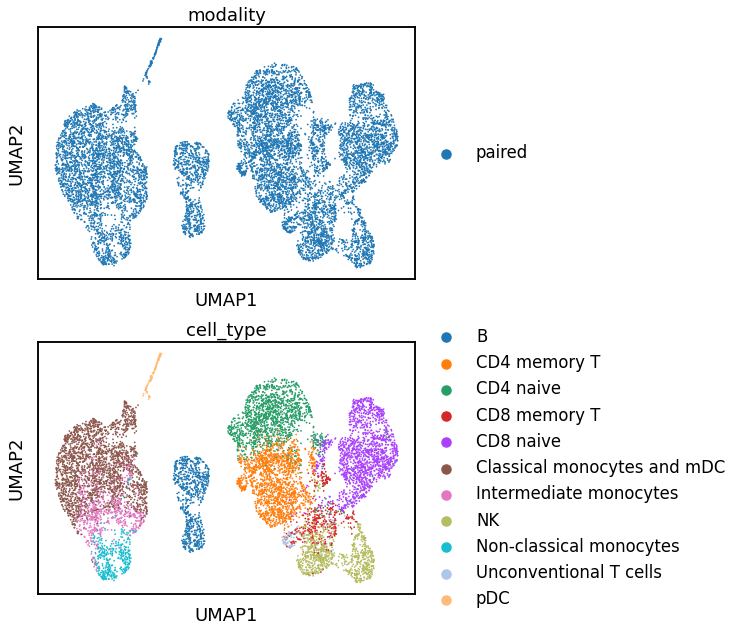

In [16]:
sc.pl.umap(adata_mvi, color=['modality', 'cell_type'], ncols=1)

In [18]:
scib_anndata = sc.AnnData(adata_mvi.obsm['MultiVI_latent']).copy()
scib_anndata.obs = adata_mvi.obs.copy()
scib_anndata.uns['neighbors'] = adata_mvi.uns['neighbors'].copy()
scib_anndata.obsp['connectivities'] = adata_mvi.obsp['connectivities'].copy()
scib_anndata.obsp['distances'] = adata_mvi.obsp['distances'].copy()
scib_anndata.obsm['MultiVI_latent'] = adata_mvi.obsm['MultiVI_latent'].copy()

In [19]:
scib_anndata.write('10x-multivi.h5ad')

In [20]:
# need to trick scIB a bit to calculate ASW cell type but not ASW batch, 
# so set batch_key to be sth random, will ignore later
scib_anndata.obs['batch'] = '0'
scib_anndata.obs['batch'][:3000] = '1'

/tmp/ipykernel_75971/3524984797.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scib_anndata.obs['batch'][:3000] = '1'


In [21]:
metrics = scib.metrics.metrics(
    scib_anndata, 
    scib_anndata, 
    batch_key='batch', 
    label_key='cell_type', 
    embed='MultiVI_latent',
    ari_=True,
    nmi_=True,
    silhouette_=True,
    graph_conn_=True,
    isolated_labels_asw_=True,
)
metrics

NMI...
ARI...
Silhouette score...
Isolated labels ASW...
Graph connectivity...


,0
NMI_cluster/label,0.775666
ARI_cluster/label,0.633357
ASW_label,0.594879
ASW_label/batch,0.976125
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,0.551268
graph_conn,0.969992
kBET,NaN


In [22]:
metrics.to_csv('10x_multivi.csv')